In [194]:
"""
Comparison of Laplace control methods
"""

import jax.numpy as jnp
from updec import *

import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='ticks',
        font='sans-serif', font_scale=1, color_codes=True, rc={"lines.linewidth": 3})

In [195]:
DATAFOLDER = "./data/Comparison/"
Nx = 100
Ny = Nx


facet_types={"North":"d", "South":"d", "West":"d", "East":"d"}

## TODO: remember to use N=100 range for the final plots
rbf_cloud = SquareCloud(Nx=Nx, Ny=Ny, facet_types=facet_types, noise_key=None, support_size=1)

In [196]:
print("Loading arrays for DAL")

dal_arrays = jnp.load(DATAFOLDER+"dal.npz")
dal_names = dal_arrays.files
print(dal_names)


# objective_cost_dal = dal_arrays["objective_cost"]
# north_mse_dal = dal_arrays["north_mse"]
# optimal_bcn_dal = dal_arrays["optimal_bcn"]
# exact_solution_dal = dal_arrays["exact_solution"]
# optimal_solution_dal = dal_arrays["optimal_solution"]

Loading arrays for DAL
['objective_cost', 'north_mse', 'exact_control', 'optimal_bcn', 'exact_solution', 'optimal_solution', 'mem_time']


In [197]:
print("Loading arrays for DP")

dp_arrays = jnp.load(DATAFOLDER+"dp.npz")
dp_names = dp_arrays.files
print(dp_names)

Loading arrays for DP
['objective_cost', 'north_mse', 'exact_control', 'optimal_bcn', 'exact_solution', 'optimal_solution', 'mem_time']


In [198]:
print("Loading arrays for PINN forward")

pinnf_arrays = jnp.load(DATAFOLDER+"pinn_forward.npz")
pinnf_names = pinnf_arrays.files
print(pinnf_names)

Loading arrays for PINN forward
['in_loss_train', 'bc_loss_train', 'total_loss_test', 'exact_solution', 'optimal_solution_test', 'mem_time']


In [199]:
print("Loading arrays for PINN inverse step 1")

Wj_id = 2
pinn1_arrays = jnp.load(DATAFOLDER+"pinn_inv_1_"+str(Wj_id)+".npz")
pinn1_names = pinn1_arrays.files
print(pinn1_names)

Loading arrays for PINN inverse step 1
['objective_cost', 'in_loss_train', 'bc_loss_train', 'exact_control', 'optimal_bcn_c', 'optimal_bcn_u', 'exact_solution', 'optimal_solution', 'mem_time_cum']


In [200]:
print("Loading arrays for PINN inverse step 2")

Wj_id = 7
pinn2_arrays = jnp.load(DATAFOLDER+"pinn_inv_2_"+str(Wj_id)+".npz")
pinn2_names = pinn2_arrays.files
print(pinn2_names)

pinn2_arrays['mem_time_cum']

Loading arrays for PINN inverse step 2
['objective_cost', 'in_loss_train', 'bc_loss_train', 'exact_control', 'optimal_bcn_c', 'optimal_bcn_u', 'exact_solution', 'optimal_solution', 'mem_time_cum']


array([1.70140212e+08, 1.33922700e+04])

In [201]:
print("Loading arrays for PINN inverse: weight vs cost")

pinn_inv_final_arrays = jnp.load(DATAFOLDER+"pinn_inv_2_final.npz")
pinn_final_names = pinn_inv_final_arrays.files
print(pinn_final_names)

Loading arrays for PINN inverse: weight vs cost
['weight_list', 'cost_list']


In [202]:
## Time vs Max Memory vs Best Accuracy for all three methods
## These arrays will be filled by hand

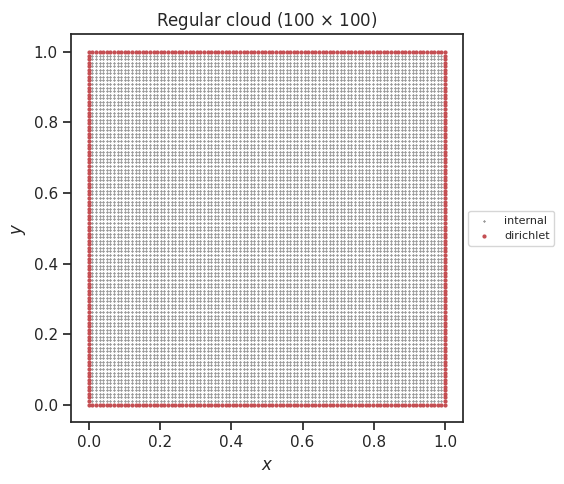

In [203]:
## Plot the regular grid
## Set control location

fig = plt.figure(figsize=(5.8, 5))
ax = fig.add_subplot(1, 1, 1)

coords = rbf_cloud.sorted_nodes
bd_size = 4

Ni, Nd, Nn = rbf_cloud.Ni, rbf_cloud.Nd, rbf_cloud.Nn
if Ni > 0:
        ax.scatter(x=coords[:Ni, 0], y=coords[:Ni, 1], c="k", label="internal", s=0.1)
if Nd > 0:
        ax.scatter(x=coords[Ni:Ni+Nd, 0], y=coords[Ni:Ni+Nd, 1], c="r", label="dirichlet", s=bd_size)
if Nn > 0:
        ax.scatter(x=coords[Ni+Nd:Ni+Nd+Nn, 0], y=coords[Ni+Nd:Ni+Nd+Nn, 1], c="g", label="neumann", s=bd_size)
if Ni+Nd+Nn < rbf_cloud.N:
        ax.scatter(x=coords[Ni+Nd+Nn:, 0], y=coords[Ni+Nd+Nn:, 1], c="b", label="robin", s=bd_size)

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_title(r"Regular cloud (100 $\times$ 100)")
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', prop={'size': 8})
plt.tight_layout()

plt.savefig(DATAFOLDER+'grid.png', dpi=2000, bbox_inches='tight')

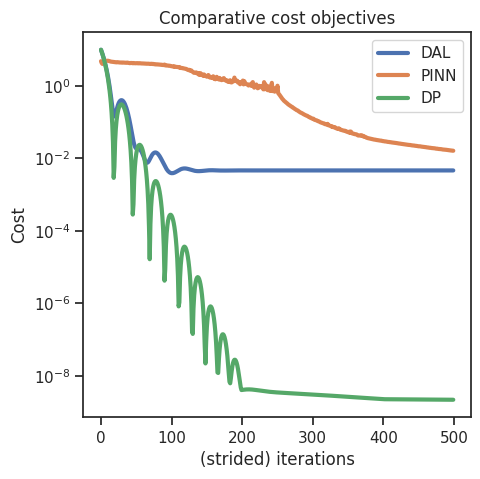

In [204]:
## Plot the cost comparison

dal_cost = dal_arrays["objective_cost"]
dp_cost = dp_arrays["objective_cost"]
pinn1_cost = pinn1_arrays["objective_cost"]
pinn2_cost = pinn2_arrays["objective_cost"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(dal_cost, label="DAL")
# ax.plot(pinn1_cost[::len(pinn1_cost)//len(dal_cost)], label="PINN")
ax.plot(pinn2_cost[::len(pinn2_cost)//len(dal_cost)], label="PINN")
ax.plot(dp_cost, label="DP")

ax.legend()
ax.set_yscale("log")
ax.set_xlabel("(strided) iterations")
# ax.set_ylabel(r"$\int_0^1 \vert \frac{\partial u}{\partial y}(x,1) - q_{d} \vert^2$ dx ")
ax.set_ylabel("Cost")
ax.set_title("Comparative cost objectives")

plt.savefig(DATAFOLDER+'costs.pdf', backend='pgf', bbox_inches='tight')

plt.show()

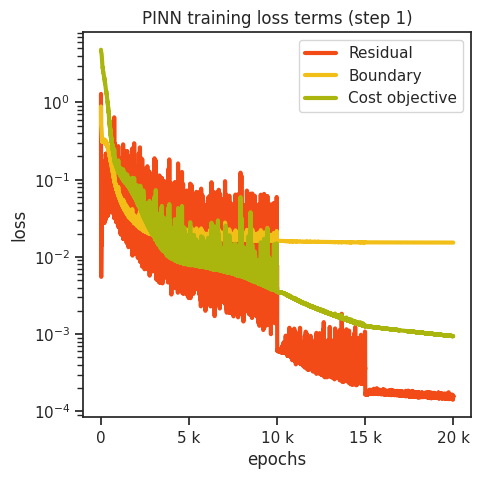

In [205]:
## Plot the PINN losses (During step 1)

pinn1_in = pinn1_arrays["in_loss_train"]
pinn1_bc = pinn1_arrays["bc_loss_train"]
pinn1_ct = pinn1_arrays["objective_cost"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
## Only use shades of orange
ax.plot(pinn1_in, label="Residual", color='#f24b18')
ax.plot(pinn1_bc, label="Boundary", color='#f2bf18')
ax.plot(pinn1_ct, label="Cost objective", color='#aab50d')

ax.xaxis.set_major_formatter(ticker.EngFormatter())

ax.legend()
ax.set_yscale("log")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.set_title("PINN training loss terms (step 1)")

plt.savefig(DATAFOLDER+'pinn_losses_step_1.pdf', backend='pgf', bbox_inches='tight')

plt.show()

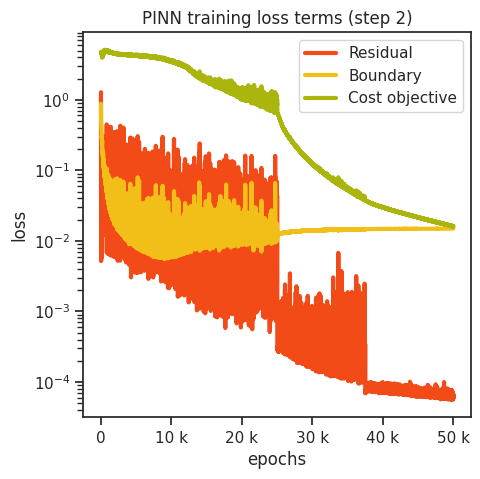

In [206]:
## Plot the PINN losses (During step 2)
pinn2_in = pinn2_arrays["in_loss_train"]
pinn2_bc = pinn2_arrays["bc_loss_train"]
pinn2_ct = pinn2_arrays["objective_cost"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(pinn2_in, label="Residual", color='#f24b18')
ax.plot(pinn2_bc, label="Boundary", color='#f2bf18')
ax.plot(pinn2_ct, label="Cost objective", color='#aab50d')

ax.xaxis.set_major_formatter(ticker.EngFormatter())

ax.legend()
ax.set_yscale("log")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.set_title("PINN training loss terms (step 2)")

plt.savefig(DATAFOLDER+'pinn_losses_step_2.pdf', backend='pgf', bbox_inches='tight')

plt.show()

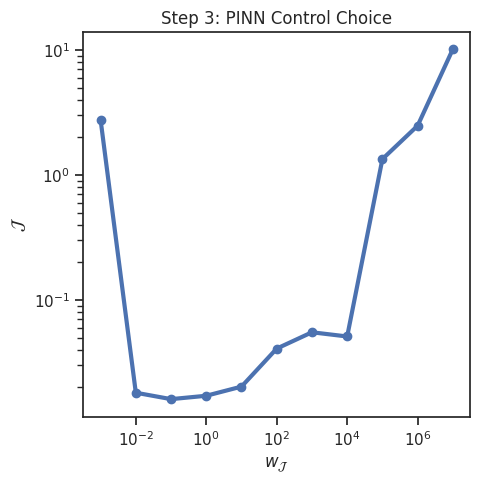

In [207]:
## Plot the cost vs weight

weights = pinn_inv_final_arrays["weight_list"]
costs = pinn_inv_final_arrays["cost_list"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(weights, costs, "o-")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$w_{\mathcal{J}}$")
ax.set_ylabel(r'$ \mathcal{J} $')
ax.set_title("Step 3: PINN Control Choice")

plt.savefig(DATAFOLDER+'pinn_choice.pdf', backend='pgf', bbox_inches='tight')

plt.show()

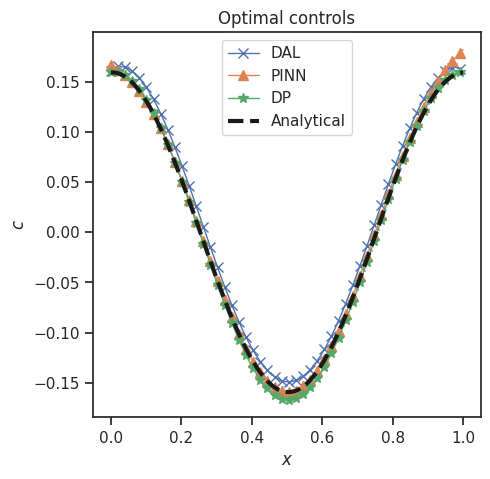

In [208]:
## Plot the control

# north_ids = cloud.facet_nodes["North"]
# x_north = cloud.sorted_nodes[north_ids, 0]

x_north = jnp.linspace(0, 1, Nx)

exact_control = dal_arrays["exact_control"]
dal_control = dal_arrays["optimal_bcn"]
pinn1_control = pinn1_arrays["optimal_bcn_c"]
# pinn2_control = pinn2_arrays["optimal_bcn_c"]
dp_control = dp_arrays["optimal_bcn"]

MKE = 2
MKS = 7
LW = 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(x_north, dal_control, "x-", markevery=MKE, markersize=MKS, lw=LW, label="DAL")
ax.plot(x_north, pinn1_control, "^-", markevery=MKE, markersize=MKS, lw=LW, label="PINN")
ax.plot(x_north, dp_control, "*-", markevery=MKE, markersize=MKS, lw=LW, label="DP")
ax.plot(x_north, exact_control, "k--", lw=3, label="Analytical")

ax.legend()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$c$")
ax.set_title("Optimal controls")

plt.savefig(DATAFOLDER+'controls.pdf', backend='pgf', bbox_inches='tight')

plt.show()

0.022284439167965575


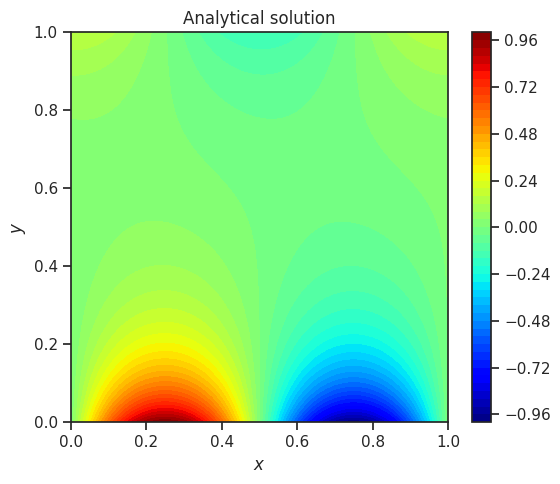

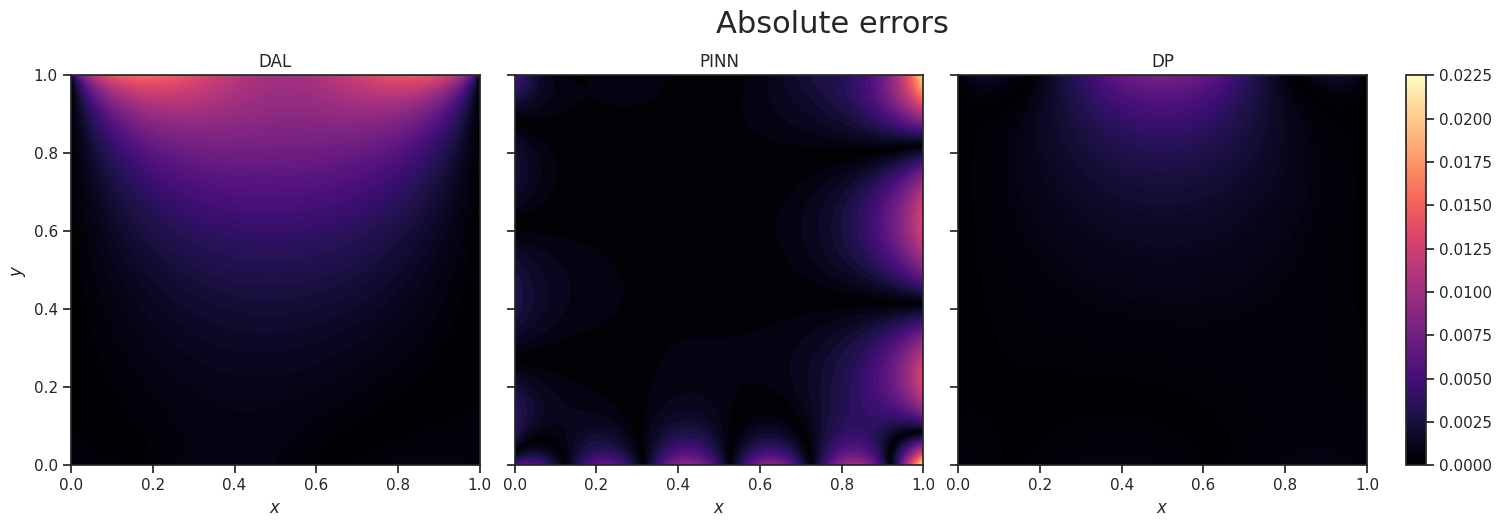

In [209]:
## Plot the Exact solution and its error

exact_solution = dal_arrays["exact_solution"]
dal_solution = dal_arrays["optimal_solution"]
pinn1_solution = pinn1_arrays["optimal_solution"]
pinn2_solution = pinn2_arrays["optimal_solution"]
dp_solution = dp_arrays["optimal_solution"]

dal_error = jnp.abs(dal_solution-exact_solution)
pinn1_error = jnp.abs(pinn1_solution-exact_solution)
# pinn2_error = jnp.abs(pinn2_solution-exact_solution)
dp_error = jnp.abs(dp_solution-exact_solution)

max_errors = max([dal_error.max(), pinn1_error.max(), dp_error.max()])
print(max_errors)
max_errors = 0.0225

pinn1_error = jnp.clip(pinn1_error, 0, max_errors)
dp_error = jnp.clip(dp_error, 0, max_errors)

fig1, ax1 = plt.subplots(1,1, figsize=(5.8*1,5))
rbf_cloud.visualize_field(exact_solution, cmap="jet", projection="2d", title="Analytical solution", ax=ax1, vmin=-1, vmax=1)

plt.savefig(DATAFOLDER+'exact_sol.pdf', backend='pgf', bbox_inches='tight')


fig2, (ax2, ax3, ax4) = plt.subplots(1,3, figsize=(5.6*3,5), sharey=True)
_, img2 = rbf_cloud.visualize_field(dal_error, cmap="magma", colorbar=False, projection="2d", title="DAL", ax=ax2, vmin=0, vmax=max_errors);
_, img3 = rbf_cloud.visualize_field(pinn1_error, cmap="magma", ylabel=None, colorbar=False, projection="2d", title="PINN", ax=ax3, vmin=0, vmax=max_errors);
_, img4 = rbf_cloud.visualize_field(dp_error, cmap="magma", ylabel=None, colorbar=False, projection="2d", title="DP", ax=ax4, vmin=0, vmax=max_errors);

fig2.suptitle("Absolute errors", y=1.05, fontsize=22)
fig2.colorbar(ScalarMappable(norm=img3.norm, cmap=img3.cmap), ax=[ax2, ax3, ax4], location="right", pad=0.025)

plt.savefig(DATAFOLDER+'errors.pdf', backend='pgf', bbox_inches='tight')

In [210]:
## Print mem times
print("On CPU")
dal_mem_time = dal_arrays["mem_time"]
print(f"    DAL mem: {dal_mem_time[0]*1e-9:.2f} GB")
print(f"    DAL time: {dal_mem_time[1]/3600:.2f} Hours")


dp_mem_time = dp_arrays["mem_time"]
print()
print(f"    DP mem: {dp_mem_time[0]*1e-9:.2f} GB")
print(f"    DP time: {dp_mem_time[1]/3600:.2f} Hours")


mems = []
times = []
for Wj_id in range(0, 11):
    pinn1_arrs = jnp.load(DATAFOLDER+"pinn_inv_1_"+str(Wj_id)+".npz")
    mems.append(pinn1_arrs["mem_time_cum"][0])
    times.append(pinn1_arrs["mem_time_cum"][1])
tot_mem1 = max(mems)
tot_time1 = max(times)

mems = []
times = []
for Wj_id in range(0, 11):
    pinn2_arrs = jnp.load(DATAFOLDER+"pinn_inv_2_"+str(Wj_id)+".npz")
    mems.append(pinn2_arrs["mem_time_cum"][0])
    times.append(pinn2_arrs["mem_time_cum"][1])
tot_mem2 = max(mems)
tot_time2 = max(times)

print()
print("On GPU")
print(f"    PINN mem: {(tot_mem1+tot_mem2)*1e-9:.2f} GB")
print(f"    PINN time: {(tot_time1+tot_time2)/3600:.2f} Hours")

On CPU
    DAL mem: 1.60 GB
    DAL time: 3.30 Hours

    DP mem: 1.60 GB
    DP time: 1.65 Hours

On GPU
    PINN mem: 0.27 GB
    PINN time: 7.29 Hours


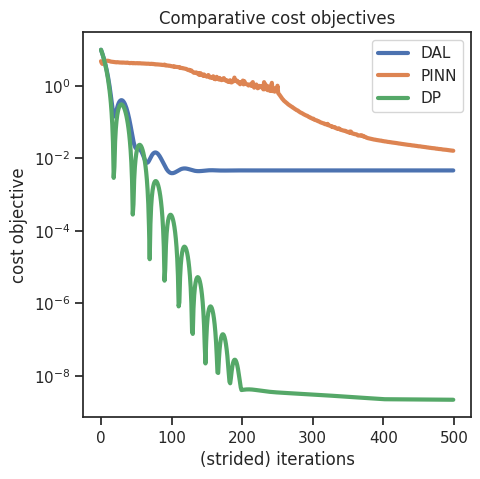

In [211]:
## Plot the cost comparison

dal_cost = dal_arrays["objective_cost"]
dp_cost = dp_arrays["objective_cost"]
pinn1_cost = pinn1_arrays["objective_cost"]
pinn2_cost = pinn2_arrays["objective_cost"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(dal_cost, label="DAL")
# ax.plot(pinn1_cost[::len(pinn1_cost)//len(dal_cost)], label="PINN")
ax.plot(pinn2_cost[::len(pinn2_cost)//len(dal_cost)], label="PINN")
ax.plot(dp_cost, label="DP")

ax.legend()
ax.set_yscale("log")
ax.set_xlabel("(strided) iterations")
# ax.set_ylabel(r"$\int_0^1 \vert \frac{\partial u}{\partial y}(x,1) - q_{d} \vert^2$ dx ")
ax.set_ylabel("cost objective")
ax.set_title("Comparative cost objectives")

plt.savefig(DATAFOLDER+'costs.pdf', backend='pgf', bbox_inches='tight')

plt.show()

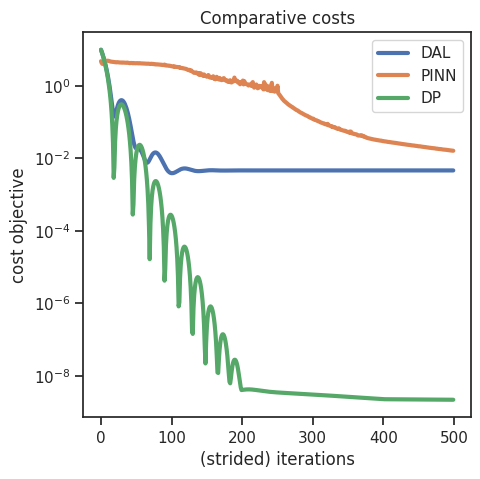

In [212]:
## Plot the cost comparison

dal_cost = dal_arrays["objective_cost"]
dp_cost = dp_arrays["objective_cost"]
pinn1_cost = pinn1_arrays["objective_cost"]
pinn2_cost = pinn2_arrays["objective_cost"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(dal_cost, label="DAL")
# ax.plot(pinn1_cost[::len(pinn1_cost)//len(dal_cost)], label="PINN")
ax.plot(pinn2_cost[::len(pinn2_cost)//len(dal_cost)], label="PINN")
ax.plot(dp_cost, label="DP")

ax.legend()
ax.set_yscale("log")
ax.set_xlabel("(strided) iterations")
# ax.set_ylabel(r"$\int_0^1 \vert \frac{\partial u}{\partial y}(x,1) - q_{d} \vert^2$ dx ")
ax.set_ylabel("cost objective")
ax.set_title("Comparative costs")

plt.savefig(DATAFOLDER+'costs.pdf', backend='pgf', bbox_inches='tight')

plt.show()

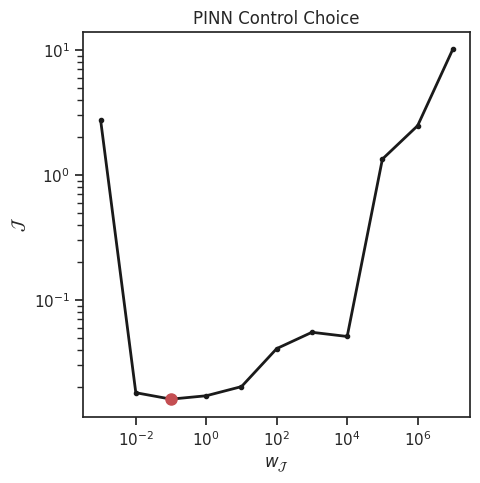

In [213]:
## Plot the cost vs weight

weights = pinn_inv_final_arrays["weight_list"]
costs = pinn_inv_final_arrays["cost_list"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(weights, costs, "k.-", lw=2)
ax.plot(weights[2], costs[2], "ro", markersize=8)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$w_{\mathcal{J}}$")
ax.set_ylabel(r'$ \mathcal{J} $')
ax.set_title("PINN Control Choice")

plt.savefig(DATAFOLDER+'pinn_choice.pdf', backend='pgf', bbox_inches='tight')

plt.show()

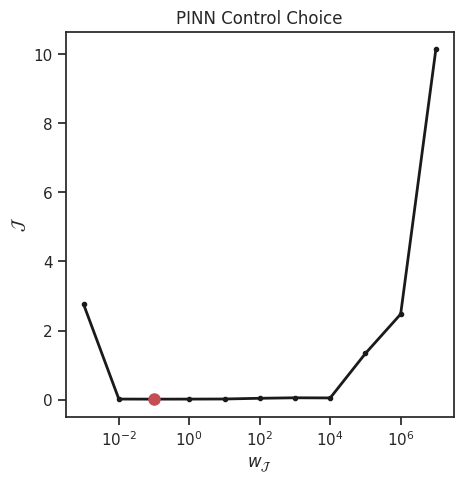

In [214]:
## Plot the cost vs weight

weights = pinn_inv_final_arrays["weight_list"]
costs = pinn_inv_final_arrays["cost_list"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(weights, costs, "k.-", lw=2)
ax.plot(weights[2], costs[2], "ro", markersize=8)

ax.set_xscale("log")
# ax.set_yscale("log")

ax.set_xlabel(r"$w_{\mathcal{J}}$")
ax.set_ylabel(r'$ \mathcal{J} $')
ax.set_title("PINN Control Choice")

plt.savefig(DATAFOLDER+'pinn_choice.pdf', backend='pgf', bbox_inches='tight')

plt.show()

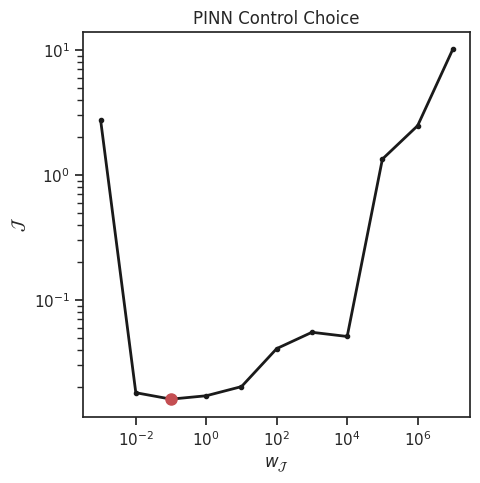

In [215]:
## Plot the cost vs weight

weights = pinn_inv_final_arrays["weight_list"]
costs = pinn_inv_final_arrays["cost_list"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(weights, costs, "k.-", lw=2)
ax.plot(weights[2], costs[2], "ro", markersize=8)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$w_{\mathcal{J}}$")
ax.set_ylabel(r'$ \mathcal{J} $')
ax.set_title("PINN Control Choice")

plt.savefig(DATAFOLDER+'pinn_choice.pdf', backend='pgf', bbox_inches='tight')

plt.show()

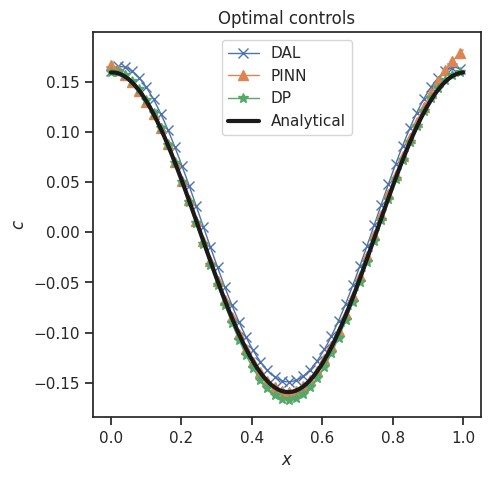

In [216]:
## Plot the control

# north_ids = cloud.facet_nodes["North"]
# x_north = cloud.sorted_nodes[north_ids, 0]

x_north = jnp.linspace(0, 1, Nx)

exact_control = dal_arrays["exact_control"]
dal_control = dal_arrays["optimal_bcn"]
pinn1_control = pinn1_arrays["optimal_bcn_c"]
# pinn2_control = pinn2_arrays["optimal_bcn_c"]
dp_control = dp_arrays["optimal_bcn"]

MKE = 2
MKS = 7
LW = 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(x_north, dal_control, "x-", markevery=MKE, markersize=MKS, lw=LW, label="DAL")
ax.plot(x_north, pinn1_control, "^-", markevery=MKE, markersize=MKS, lw=LW, label="PINN")
ax.plot(x_north, dp_control, "*-", markevery=MKE, markersize=MKS, lw=LW, label="DP")
ax.plot(x_north, exact_control, "k-", lw=3, label="Analytical")

ax.legend()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$c$")
ax.set_title("Optimal controls")

plt.savefig(DATAFOLDER+'controls.pdf', backend='pgf', bbox_inches='tight')

plt.show()